# Geoprocessing with Geodatabases

In [103]:
import psycopg2
import requests
from shapely.geometry import Point,Polygon,MultiPolygon, mapping
import datetime
from shapely.wkb import loads
from shapely.wkt import dumps, loads
import json
import folium 
from shapely.geometry import mapping
import ipywidgets as widgets
import pandas as pd
from IPython.display import Image

import all the packges I will use. psycopg2 use for connecting and manipulating your PostgreSQL 
database in Python.

In [104]:
connection = psycopg2.connect(database="myspatialdb",user="useroh",password="geog482")

Connect to database, put user name and password in.

In [105]:
cursor = connection.cursor()

Creating the connection and getting the cursor.

In [106]:
connection.rollback()

In [107]:
cursor.execute("CREATE TABLE areacommand (id SERIAL PRIMARY KEY, name VARCHAR(20), geom GEOMETRY)") 
cursor.execute("CREATE TABLE beats (id SERIAL PRIMARY KEY, beat VARCHAR(6),agency VARCHAR(3), areacomm VARCHAR(15),geom GEOMETRY)")
cursor.execute("CREATE TABLE incidents (id SERIAL PRIMARY KEY, address VARCHAR(72), crimetype VARCHAR(255), date DATE,geom GEOMETRY)")

Creating three table: areacommand, beats, and incidents. the areacommand table with a field for the name 
and a GEOMETRY field. VARCHAR() means that given the table an empty field with a length of number. 

In [108]:
connection.commit()

commit() to make sure the changes are saved.

In [109]:
# Populating the data
url='http://coagisweb.cabq.gov/arcgis/rest/services/public/adminboundaries/MapServer/8/query'

Using the requests library to query the URL.

In [110]:
params = {'where':'1=1','outFields':'*','outSR':'4326','f':'json'}
r = requests.get(url,params=params)
data = r.json()

for acmd in data['features']:
    polys = []
    for ring in acmd['geometry']['rings']:
        polys.append(Polygon(ring))
    p = MultiPolygon(polys)
    name = acmd['attributes']['Area_Command']
    cursor.execute("INSERT INTO areacommand (name, geom) VALUES ('{}',ST_GeomFromText('{}'))".format(name, p.wkt))
    
connection.commit()

Grab the area commands and insert them into the table of areacommand.
The parameters are saved as a list object called params. 
The paramaters just grab all the data (1=1), and grab all the fields (*), 
the geometry is in the coordinate reference system 4326 and accessing everything as a json. 
The results are loaded in the variable data using the json() method.

In [111]:
url='http://coagisweb.cabq.gov/arcgis/rest/services/public/adminboundaries/MapServer/9/query'

params={"where":"1=1","outFields":"*","outSR":"4326","f":"json"}
r=requests.get(url,params=params)
data=r.json()

for acmd in data['features']:
    polys=[]
    for ring in acmd['geometry']['rings']:
        polys.append(Polygon(ring))
    p=MultiPolygon(polys)
    beat = acmd['attributes']['BEAT']
    agency = acmd['attributes']['AGENCY']
    areacomm = acmd['attributes']['AREA_COMMA']
    cursor.execute("INSERT INTO beats (beat, agency,areacomm,geom) VALUES ('{}','{}','{}', ST_GeomFromText('{}'))".format(beat,agency,areacomm,p.wkt))
    
connection.commit()

Populating the data and insert them into the table of beats.

In [112]:
url='http://coagisweb.cabq.gov/arcgis/rest/services/public/APD_Incidents/MapServer/0/query'

params={"where":"1=1","outFields":"*","outSR":"4326","f":"json"}
r=requests.get(url,params=params)
data=r.json()

for a in data['features']:
    address = a['attributes']['BlockAddress']
    crimetype = a['attributes']['IncidentType']
    if a['attributes']['date'] is None:
        pass
    else:
        date = datetime.datetime.fromtimestamp(a['attributes']['date'] /1e3).date()
    try:
        p = Point(float(a['geometry']['x']), float(a['geometry']['y']))
        cursor.execute("INSERT INTO incidents (address,crimetype,date,geom) VALUES ('{}','{}','{}',ST_GeomFromText('{}'))".format(address,crimetype,str(date), p.wkt))
    except KeyError:
        pass

connection.commit()

Grabing the incidents and insert them into the table of incidents.

## Q1. Find the number of incidents in the past 60 days within a 500 meter buffer from the old town (-106.6717236, 35.0959965)

### 1-1. Provide the code to produce the buffer and find the incident locations

In [113]:
center = [35.0959965, -106.6717236]
zoom = 16
map_1 = folium.Map(location=center, zoom_start=zoom)

Create map_1, center is located in the old town (-106.6717236, 35.0959965), and seting zoom as 16.

In [114]:
p = Point([-106.6717236, 35.0959965])
pgeojson = mapping(p)
folium.GeoJson(data=pgeojson).add_to(map_1)
map_1

Creating a point using Shapely I import a library above. 
It converts it to GeoJSON using shapely.geometry.mapping().
Then show the map_1 above.

In [115]:
cursor.execute("SELECT ST_AsGeoJSON(ST_Buffer(ST_GeomFromText('{}')::geography,500));".format(p.wkt))
buff = cursor.fetchall()

buffer = json.loads(buff[0][0])
folium.GeoJson(data=buffer).add_to(map_1)

map_1

Using ST_Buffer() to get a polygon back from PostGIS. 
ST_Buffer() can take a point geography and a radius in 500 meters to return the polygon.
The code loads the result buff[0][0] and maps map_1.

In [116]:
cursor.execute("SELECT ST_AsText(ST_Buffer(ST_GeomFromText('{}')::geography,500));".format(p.wkt))
bufferwkt = cursor.fetchall()
b = loads(bufferwkt[0][0])

These codes pass the shape of the buffer's 500-meter range to b.

In [117]:
cursor.execute("SELECT ST_AsGeoJSON(i.geom) FROM incidents i where ST_Intersects(ST_GeomFromText('{}'), i.geom) and date >= NOW() - interval '60 day';".format(b.wkt))
crime=cursor.fetchall()
crime

[]

Through these lines of code, I get that there is no incident in the past 60 days 
within 500 miters buffer from the old town.

### 1-2. Produce a map with a buffer from the old town and incidents points and take a screenshot.

In [118]:
for x in crime:
    layer=json.loads(x[0])
    folium.GeoJson(data=layer).add_to(q1_map)

Produce the map with a buffer from the old town.

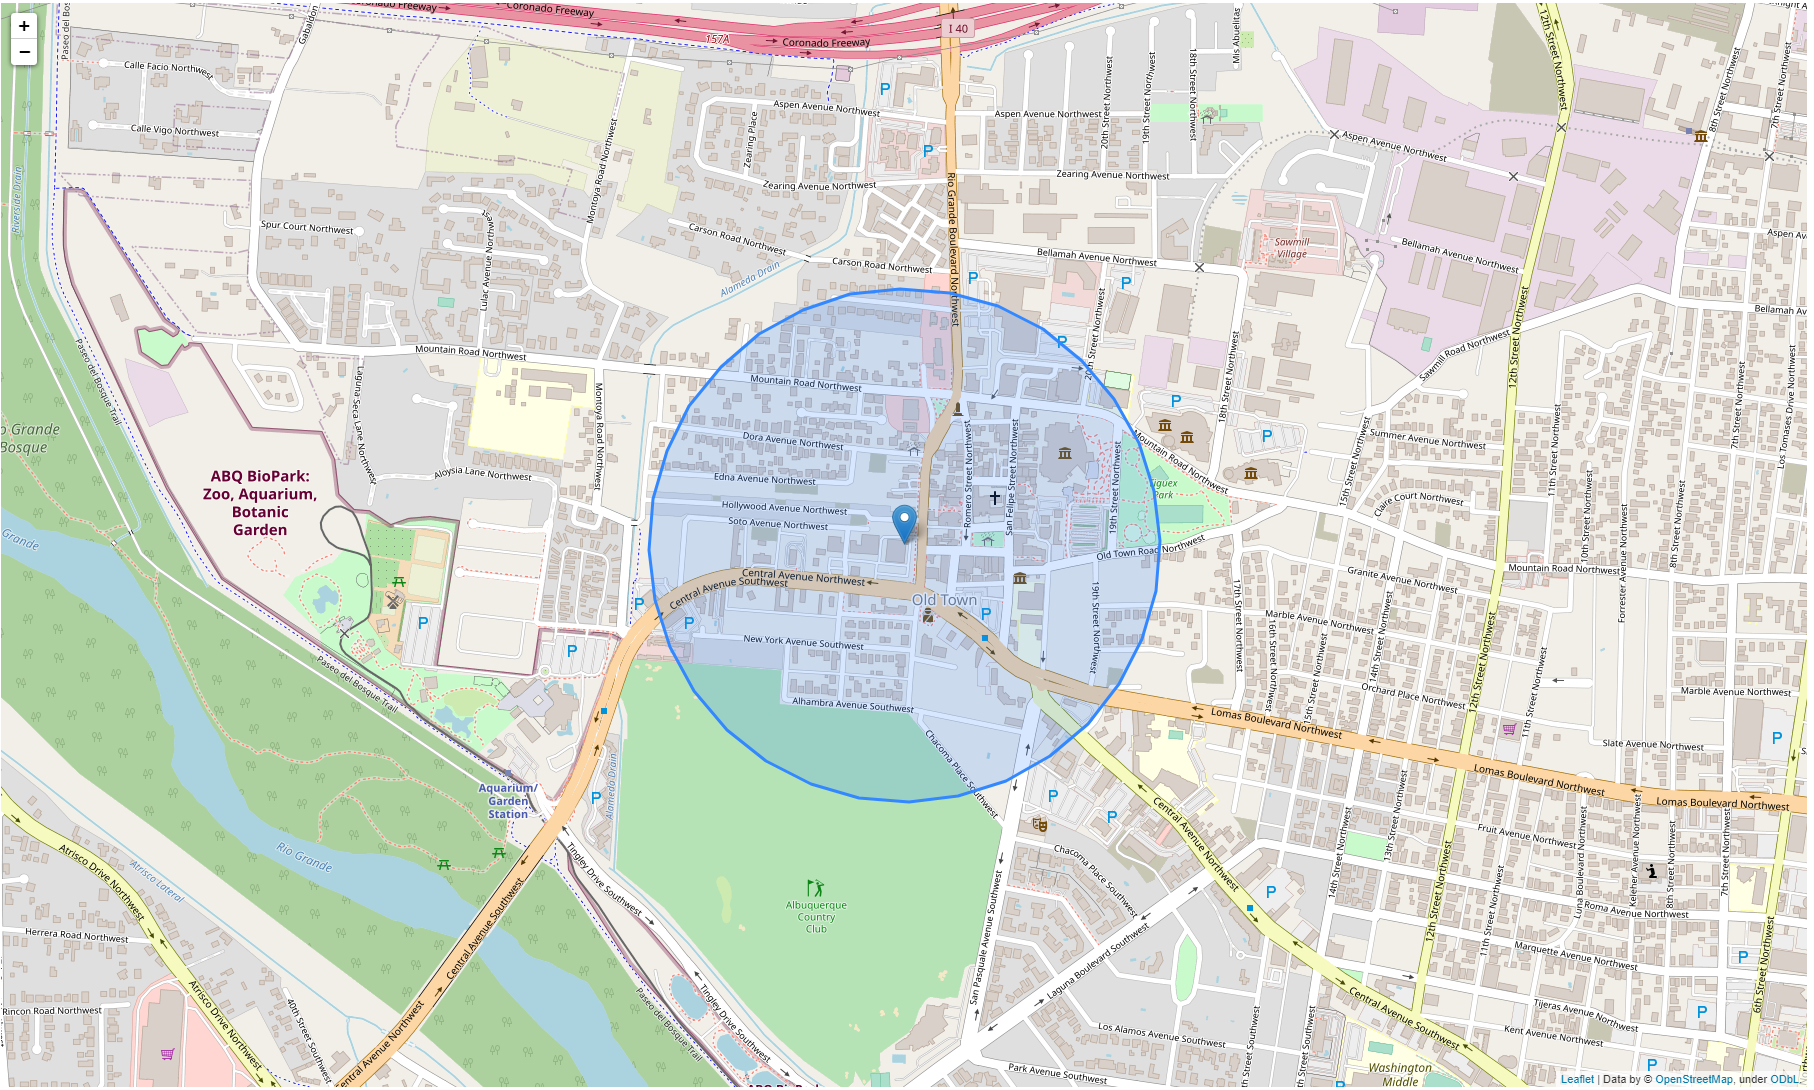

In [119]:
Image(filename='img/Q1-2.png')

The map above is a screenshot.

## Q2. Find the area with the highest number of incidents in the past 60 days using the areacommand widget

### 2-1. Produce the areacommand widget with the time period properly specified. 

In [120]:
center = [35.0959965, -106.6717236]
zoom = 12
map_2 = folium.Map(location=center, zoom_start=zoom)

Create map_2, center is located in the old town (-106.6717236, 35.0959965), and seting zoom as 12.

In [121]:
cursor.execute("SELECT name FROM areacommand;")
areaName = cursor.fetchall()
areaName

[('FOOTHILLS',),
 ('NORTHEAST',),
 ('NORTHWEST',),
 ('SOUTHEAST',),
 ('SOUTHWEST',),
 ('VALLEY',)]

Using SQL to produce a list of all the area names.

In [122]:
@widgets.interact(x='None')

def areacommand(x):
    if x:
        cursor.execute("SELECT ST_AsGeoJSON(i.geom) FROM incidents i JOIN areacommand acmd ON ST_Intersects(acmd.geom, i.geom) WHERE acmd.name like'{}' and date >= NOW() - interval '60day';".format(x))
        c = cursor.fetchall()
        
        for x in c:
            layer = json.loads(x[0])
            folium.GeoJson(data=layer).add_to(map_2)
            
        return c
    else:
        pass

interactive(children=(Text(value='None', description='x'), Output()), _dom_classes=('widget-interact',))

I produce a text box where I can type in the name of an area. I did not put the name, so output is empty.
These codes are using ipywidgets to import interact, which allow me to insert an interactive text 
box to subset my results by area.
And I ues these codes to produce the areacommand widget within the past 60 days.

In [123]:
map_2

I make a blank map to show this area.

### 2-2. In the areacommand widget, type in an area name of your choice and produce an interactive map showing incidents for that area. Display this map in your final document

In [124]:
@widgets.interact(x='VALLEY')

def areacommand(x):
    if x:
        cursor.execute("SELECT ST_AsGeoJSON(i.geom) FROM incidents i JOIN areacommand acmd ON ST_Intersects(acmd.geom, i.geom) WHERE acmd.name like'{}' and date >= NOW() - interval '60day';".format(x))
        c = cursor.fetchall()
        
        for x in c:
            layer = json.loads(x[0])
            folium.GeoJson(data=layer).add_to(map_2)
            
        return c
    else:
        pass

interactive(children=(Text(value='VALLEY', description='x'), Output()), _dom_classes=('widget-interact',))

I put the the name of area - 'VALLEY' in text box to produce the incidents in this area. output shows 
the location of 'Valley'. There is one incident in Valley.

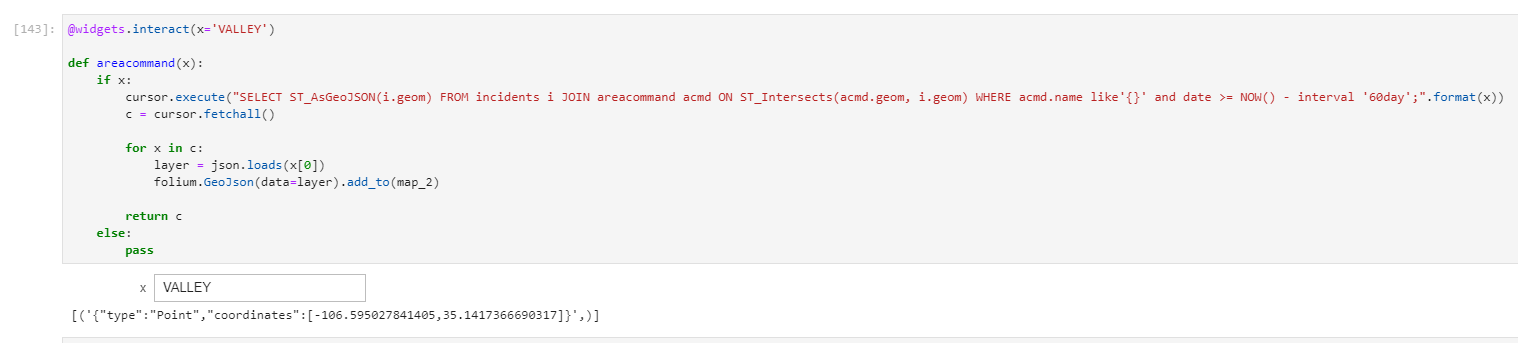

In [125]:
Image(filename='img/Q2-2.png')

I check my html file that it does not show the output my above code run out, so I insert a screenshot here.
This screenshot show what last line of code produced.

In [126]:
map_2

I make a map show the point and location of Valley.

### 2-3. Using a method of your choice, find the area with the greatest number of incidents in this time period. Show the method you used to determine this area, give the name of the area and the number of incidents

In [127]:
cursor.execute("SELECT ac.name, count(i.geom) From areacommand ac LEFT JOIN incidents i on ST_Intersects(ac.geom, i.geom) WHERE i.date >= (NOW() - interval '60 day') GROUP BY ac.name ORDER BY COUNT(i.geom) DESC")
area = pd.DataFrame(cursor.fetchall(), columns=["Area", "Incidents"])
area

,Area,Incidents
0,FOOTHILLS,3
1,NORTHEAST,3
2,SOUTHWEST,3
3,SOUTHEAST,1
4,VALLEY,1


The greatest number of incidents in the past 60 days is 3. They happened in Foothills, Northeast, 
and Southwest. The smallest number is 1. They happened in Southeast and Valley.
I use SQL command to select name, and left join areas and incidents. 
The DataFrame is populated using DataFrame (SQL, columns).